In [1]:
import numpy as np

In [2]:
def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform between corresponding 3D points A->B
    Input:
      A: Nx3 numpy array of corresponding 3D points
      B: Nx3 numpy array of corresponding 3D points
    Returns:
      T: 4x4 homogeneous transformation matrix
      R: 3x3 rotation matrix
      t: 3x1 column vector
    '''

    assert len(A) == len(B)

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    W = np.dot(BB.T, AA)
    U, s, VT = np.linalg.svd(W, full_matrices=True, compute_uv=True)
    R = np.dot(U, VT)

    # special reflection case
    if np.linalg.det(R) < 0:
        VT[2,:] *= -1
        R = np.dot(U, VT)


    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(4)
    T[0:3, 0:3] = R
    T[0:3, 3] = t

    return T, R, t

In [3]:
def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nx3 array of points
        dst: Nx3 array of points
    Output:
        distances: Euclidean distances (errors) of the nearest neighbor
        indecies: dst indecies of the nearest neighbor
    '''

    indecies = np.zeros(src.shape[0], dtype=np.int)
    distances = np.zeros(src.shape[0])
    for i, s in enumerate(src):
        min_dist = np.inf
        for j, d in enumerate(dst):
            dist = np.linalg.norm(s-d)
            if dist < min_dist:
                min_dist = dist
                indecies[i] = j
                distances[i] = dist
    return distances, indecies

In [4]:
def icp(A, B, init_pose=None, max_iterations=50, tolerance=0.001):
    '''
    The Iterative Closest Point method
    Input:
        A: Nx3 numpy array of source 3D points
        B: Nx3 numpy array of destination 3D point
        init_pose: 4x4 homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation
        distances: Euclidean distances (errors) of the nearest neighbor
    '''

    # make points homogeneous, copy them so as to maintain the originals
    src = np.ones((4,A.shape[0]))  #(4, A.shape[0])
    dst = np.ones((4,B.shape[0]))
    src[0:3,:] = np.copy(A.T)  # A.T shape (3,20)
    dst[0:3,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbours between the current source and destination points
        distances, indices = nearest_neighbor(src[0:3,:].T, dst[0:3,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[0:3,:].T, dst[0:3,indices].T)  #将dst[]按照indices排序

        # update the current source
    # refer to "Introduction to Robotics" Chapter2 P28. Spatial description and transformations
        src = np.dot(T, src)

        # check error
        mean_error = np.sum(distances) / distances.size
        if abs(prev_error-mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculcate final tranformation
    T,_,_ = best_fit_transform(A, src[0:3,:].T)

    return T, distances

In [33]:
if __name__ == "__main__":
    A = np.random.randint(0,101,(20,3))    # 20 points for test
    
    rotz = lambda theta: np.array([[np.cos(theta),-np.sin(theta),0],
                                   [np.sin(theta), np.cos(theta),0],
                                   [0            , 0            ,1]])
    
    trans = np.array([2.12,-0.2,1.3])
    B = A.dot(rotz(np.pi/4).T) + trans
    
    T, distances = icp(A, B)

    np.set_printoptions(precision=3,suppress=True)
    print (T,'\n')
    print(np.transpose(np.hstack((A,np.ones([A.shape[0],1]))))[:,:5])
    A = np.hstack((A,np.ones([A.shape[0],1])))

[[ 0.707 -0.707  0.     2.12 ]
 [ 0.707  0.707  0.    -0.2  ]
 [ 0.     0.     1.     1.3  ]
 [ 0.     0.     0.     1.   ]] 

[[ 63.  29.  60.  65.  16.]
 [ 69.  12.  88.  21.  69.]
 [ 52.  46.  81.  17.  30.]
 [  1.   1.   1.   1.   1.]]


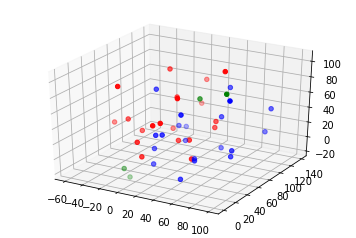

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(A[:,0],A[:,1],A[:,2],c='b')
ax.scatter(B[:,0],B[:,1],B[:,2],c='r')

AT = np.matmul(T,np.transpose(A))
ax.scatter(AT[:,0],AT[:,1],AT[:,2],c='g')